In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cirpy
import seaborn as sns
import re

In [48]:
# Some things still worth doing: filter out species, recover some bad CAS-SMILES conversions
eco = pd.read_excel("ECOTOX_Aquatic_BCF.xlsx")

uci = pd.read_csv("QSAR_BCF_Kow.csv")

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [30]:
# Overview of ECOTOX dataset
eco

,CAS Number,Chemical Name,Chemical Grade,Chemical Analysis,Chemical Purity,Species Scientific Name,Species Common Name,Species Group,Organism Lifestage,Organism Age,...,BCF 3 Min,BCF 3 Max Op,BCF 3 Max,BCF 3 Unit,Author,Reference Number,Title,Source,Publication Year,Summary of Additional Parameters
0,50044.0,"17-Hydroxy-3,11,20-trioxopregn-4-en-21-yl acetate",NaN,Unmeasured values (some measured values report...,>98,Leuciscus idus ssp. melanotus,Carp,Fish,NaN,NR,...,NaN,NaN,NaN,NaN,"Freitag,D., L. Ballhorn, H. Geyer, and F. Korte",3782.0,Environmental Hazard Profile of Organic Chemic...,Chemosphere14(10): 1589-1616,1985.0,Purity: NR - NR | Organism Age: NR - NR NR |...
1,50044.0,"17-Hydroxy-3,11,20-trioxopregn-4-en-21-yl acetate",NaN,Measured,NR,Leuciscus idus ssp. melanotus,Carp,Fish,NaN,NR,...,NaN,NaN,NaN,NaN,"Freitag,D., H. Geyer, A. Kraus, R. Viswanathan...",3781.0,Ecotoxicological Profile Analysis VII. Screeni...,Ecotoxicol. Environ. Saf.6:60-81,1982.0,Purity: NR - NR | Organism Age: NR - NR NR |...
2,50282.0,"(17beta)Estra-1,3,5(10)triene-3,17-diol",NaN,Unmeasured,NR,Zoarces viviparus,Viviporous Blenny,Fish; Standard Test Species,Gestation,NR,...,NaN,NaN,NaN,NaN,"Rasmussen,T.H., T.K. Andreassen, S.N. Pedersen...",82314.0,Effects of Waterborne Exposure of Octylphenol ...,J. Exp. Biol.205(24): 3857-3876,2002.0,Purity: NR - NR | Organism Age: NR - NR NR |...
3,50282.0,"(17beta)Estra-1,3,5(10)triene-3,17-diol",NaN,Unmeasured,NR,Zoarces viviparus,Viviporous Blenny,Fish; Standard Test Species,Gestation,NR,...,NaN,NaN,NaN,NaN,"Rasmussen,T.H., T.K. Andreassen, S.N. Pedersen...",82314.0,Effects of Waterborne Exposure of Octylphenol ...,J. Exp. Biol.205(24): 3857-3876,2002.0,Purity: NR - NR | Organism Age: NR - NR NR |...
4,50293.0,"1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobe...",NaN,Measured,NR,Gambusia affinis,Western Mosquitofish,Fish,NaN,NR,...,NaN,NaN,NaN,NaN,"Pillai,M.K.K., H.C. Agarwal, and D.V. Yadav",6978.0,"Tolerance, Uptake and Metabolism of DDT in Gam...",Indian J. Exp. Biol.15(1): 40-41,1977.0,Purity: NR - NR | Organism Age: NR - NR NR |...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9495,500776692.0,bis(Heptadecafluorooctyl)phosphinic acid sodiu...,NaN,Measured,>96,Cyprinus carpio,Common Carp,Fish; Standard Test Species,NaN,NR,...,NaN,NaN,NaN,NaN,"Liu,M., F. Dong, S. Yi, Y. Zhu, J. Zhou, B. Su...",182551.0,Probing Mechanisms for the Tissue-Specific Dis...,Environ. Sci. Technol.:4932-4941,2020.0,Purity: NR - NR | Organism Age: NR - NR NR |...
9496,500776692.0,bis(Heptadecafluorooctyl)phosphinic acid sodiu...,NaN,Measured,>96,Cyprinus carpio,Common Carp,Fish; Standard Test Species,NaN,NR,...,NaN,NaN,NaN,NaN,"Liu,M., F. Dong, S. Yi, Y. Zhu, J. Zhou, B. Su...",182551.0,Probing Mechanisms for the Tissue-Specific Dis...,Environ. Sci. Technol.:4932-4941,2020.0,Purity: NR - NR | Organism Age: NR - NR NR |...
9497,500776692.0,bis(Heptadecafluorooctyl)phosphinic acid sodiu...,NaN,Measured,>96,Cyprinus carpio,Common Carp,Fish; Standard Test Species,NaN,NR,...,NaN,NaN,NaN,NaN,"Liu,M., F. Dong, S. Yi, Y. Zhu, J. Zhou, B. Su...",182551.0,Probing Mechanisms for the Tissue-Specific Dis...,Environ. Sci. Technol.:4932-4941,2020.0,Purity: NR - NR | Organism Age: NR - NR NR |...
9498,960374065.0,Bioplex Cu,NaN,Measured,NR,Oncorhynchus mykiss,Rainbow Trout,Fish; Standard Test Species; U.S. Threatened a...,Juvenile,NR,...,NaN,NaN,NaN,NaN,"Kjoss,V.A., C.M. Wood, and D.G. McDonald",100003.0,Effects of Different Ligands on the Bioaccumul...,Can. J. Fish. Aquat. Sci.63(2): 412-422,2006.0,Purity: NR - NR | Organism Age: NR - NR NR |...


In [7]:
# How many distinct compounds are there in this dataset?
print("There are ", eco["CAS Number"].nunique(), " unique compounds")

There are  674  unique compounds


,index,CAS Number
0,10108642.0,342
1,115093.0,228
2,10102188.0,221
3,2921882.0,205
4,118741.0,193
...,...,...
95,7733020.0,26
96,104405.0,26
97,1071836.0,26
98,10325947.0,26


In [39]:
# Count missing value
print("Count total NaN at each column in a DataFrame:")
eco.isnull().sum()

# Note, we have missing BCF 1 Values

Count total NaN at each column in a DataFrame:


CAS Number                             0
Chemical Name                          0
Chemical Grade                      8130
Chemical Analysis                    183
Chemical Purity                        0
Species Scientific Name                0
Species Common Name                    0
Species Group                          0
Organism Lifestage                  5805
Organism Age                           0
Age Units                           7710
Exposure Type                        529
Media Type                             0
Test Location                         22
Number of Doses                     6415
Conc 1 Type (Standardized)             0
Conc 1 Mean Op (Standardized)       9402
Conc 1 Mean (Standardized)          1425
Conc 1 Min Op (Standardized)        9480
Conc Min 1 (Standardized)           7676
Conc 1 Max Op (Standardized)        9491
Conc 1 Max (Standardized)           7676
Conc 1 Units (Standardized)           12
Effect                                 0
Effect Measureme

In [31]:
# Check if there may be bad labels, non-fish in dataset
eco["Species Group"].value_counts()

Fish; Standard Test Species                                            5269
Fish                                                                   2615
Fish; Standard Test Species; U.S. Threatened and Endangered Species    1583
Fish; U.S. Invasive Species                                              33
Name: Species Group, dtype: int64

In [33]:
# Will need to convert units
eco["BCF 1 Unit"].value_counts()

L/kg          8241
RA             760
mg/L           131
L/g            113
ml/g           108
g/ml            60
ug/g            21
kg/L            13
ug/kg bdwt       5
NR               5
ug/L             4
mg/kg bdwt       2
g/L              2
mg/kg            1
Name: BCF 1 Unit, dtype: int64

In [34]:
# Keep only response site for whole body or muscle tissue
eco["Response Site"].value_counts()

Whole organism                3621
Muscle                         495
Gill(s)                        388
Liver                          331
Residual, remnant, carcass     156
Brain                          149
Lipid, fat                     126
Viscera                        120
Kidney                         119
Tissue                         100
Multiple tissueorgan            80
Plasma                          74
Egg                             69
Intestinal tract                66
Blood                           66
Skin, epidermis                 53
Gonad(s)                        50
Bile                            47
Skeleton                        39
Gut                             32
Edible tissue                   31
Yolk                            29
Ovaries                         27
Multiple sites                  25
Testes                          25
Heart                           24
Bone                            18
Trunk kidney                    16
Head kidney (proneph

[Text(0, 0, 'Rainbow Trout'),
 Text(1, 0, 'Common Carp'),
 Text(2, 0, 'Fathead Minnow'),
 Text(3, 0, 'Bluegill'),
 Text(4, 0, 'Zebra Danio'),
 Text(5, 0, 'Japanese Medaka'),
 Text(6, 0, 'Guppy'),
 Text(7, 0, 'Sheepshead Minnow'),
 Text(8, 0, 'Goldfish'),
 Text(9, 0, 'Western Mosquitofish'),
 Text(10, 0, 'Channel Catfish'),
 Text(11, 0, 'Largemouth Bass'),
 Text(12, 0, 'Atlantic Salmon'),
 Text(13, 0, 'Mozambique Tilapia'),
 Text(14, 0, 'Ide, Silver Or Golden Orfe'),
 Text(15, 0, 'Banded Bream'),
 Text(16, 0, 'Tilapia'),
 Text(17, 0, 'Motsuga, Stone Moroko'),
 Text(18, 0, 'Mummichog'),
 Text(19, 0, 'Minnow,Carp Family'),
 Text(20, 0, 'Brook Trout'),
 Text(21, 0, 'Threespine Stickleback'),
 Text(22, 0, 'White Cloud Mountain Minnow'),
 Text(23, 0, 'Biwi Lake Gudgeon Or Goby'),
 Text(24, 0, 'Longnose Killifish'),
 Text(25, 0, 'Nile Tilapia'),
 Text(26, 0, 'Zambezi Barbel'),
 Text(27, 0, 'Red Sea Bream'),
 Text(28, 0, 'Striped Mullet'),
 Text(29, 0, 'Carp'),
 Text(30, 0, 'Minnow'),
 Text(31

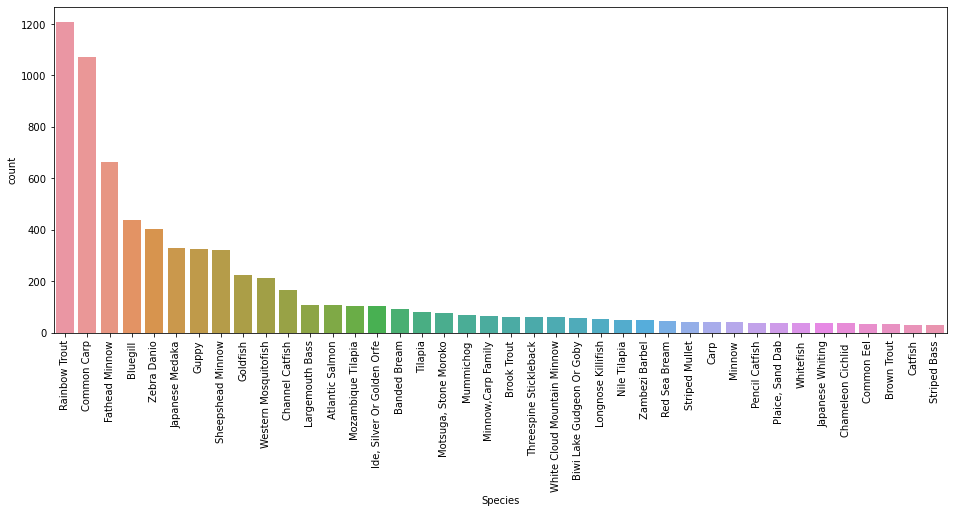

In [47]:
# Species common names - prefer "common" to "rare" species
s = eco["Species Common Name"].value_counts()
species = s.head(n=40).to_frame().reset_index()
species.columns = ['Species', 'count']

plt.figure(figsize=(16, 6))
bar = sns.barplot(data=species, x='Species', y='count')
bar.set_xticklabels(bar.get_xticklabels(), rotation = 90)

# Will likely have to filter for common species

In [49]:
# Convert BCF 1 Value to float, CAS Number to integer (to rid float) then to string
eco["BCF 1 Value"] = pd.to_numeric(eco["BCF 1 Value"], errors = 'coerce')
eco["CAS Number"] = eco["CAS Number"].astype(int)
eco["CAS Number"] = eco["CAS Number"].astype(str)
# eco.dtypes

# Get rid of missing BCF, CAS Number rows
eco.dropna(subset=['CAS Number', 'BCF 1 Value'], inplace=True)

[Text(0, 0, '10108642'),
 Text(1, 0, '115093'),
 Text(2, 0, '2921882'),
 Text(3, 0, '118741'),
 Text(4, 0, '7487947'),
 Text(5, 0, '333415'),
 Text(6, 0, '10102188'),
 Text(7, 0, '7758987'),
 Text(8, 0, '117817'),
 Text(9, 0, '84852153'),
 Text(10, 0, '7646857'),
 Text(11, 0, '1912249'),
 Text(12, 0, '58899'),
 Text(13, 0, '122145'),
 Text(14, 0, '121824'),
 Text(15, 0, '143500'),
 Text(16, 0, '994310'),
 Text(17, 0, '2104645'),
 Text(18, 0, '120821'),
 Text(19, 0, '87865'),
 Text(20, 0, '115297'),
 Text(21, 0, '115866'),
 Text(22, 0, '7440439'),
 Text(23, 0, '319846'),
 Text(24, 0, '84742'),
 Text(25, 0, '106467'),
 Text(26, 0, '91203'),
 Text(27, 0, '8001352'),
 Text(28, 0, '26087478'),
 Text(29, 0, '10102064'),
 Text(30, 0, '51630581'),
 Text(31, 0, '22967926'),
 Text(32, 0, '121755'),
 Text(33, 0, '11097691'),
 Text(34, 0, '1746016'),
 Text(35, 0, '55389'),
 Text(36, 0, '72559'),
 Text(37, 0, '1582098'),
 Text(38, 0, '10099599'),
 Text(39, 0, '537462'),
 Text(40, 0, '56382'),
 Text

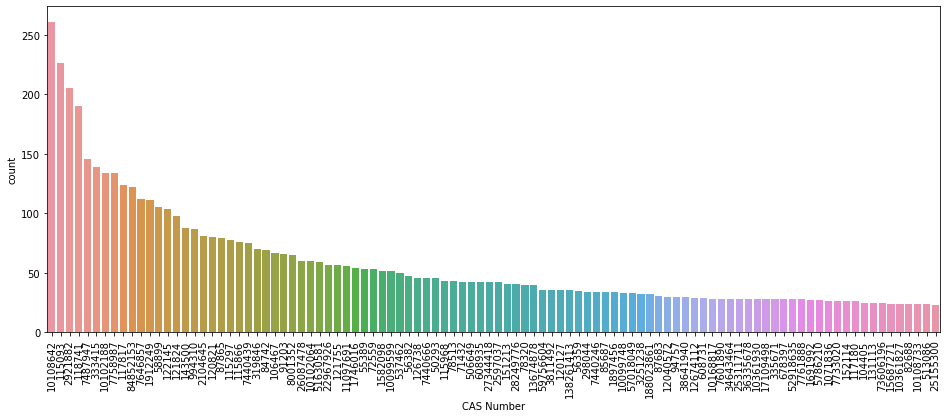

In [10]:
# The most repeated chemical is repeated 342 times! Will need to deal with these repeats.
repeated = eco["CAS Number"].value_counts()
x = repeated.head(n=100).to_frame().reset_index()
x.columns = ['CAS Number', 'count']
# subplot = repeated.head(n=20).plot(kind='bar')
plt.figure(figsize=(16, 6))
bar = sns.barplot(data=x, x='CAS Number', y='count')
bar.set_xticklabels(bar.get_xticklabels(), rotation = 90)

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys

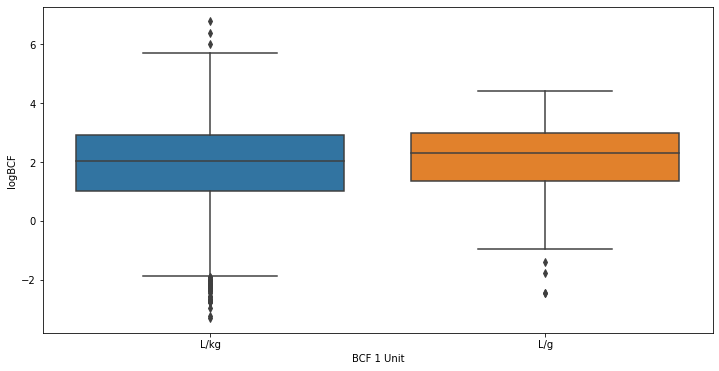

In [76]:
# Visualizations of BCF 1 Values

# Boxplot distribution of BCF values for L/kg, L/g
# eco[eco['BCF 1 Unit'] == 'L/g']['BCF 1 Value'].hist(bins=20)

# Boxplot of BCF values for L/kg
filt1 = (eco['BCF 1 Unit'] == 'L/kg')
filt2 = (eco['BCF 1 Unit'] == 'L/g')
a = eco[filt1]
b = eco[filt2]
a['logBCF'] = np.log10(a['BCF 1 Value'])
b['logBCF'] = np.log10(b['BCF 1 Value'])
c = pd.concat([a,b])
plt.figure(figsize=(12, 6))
box = sns.boxplot(data = c, x = 'BCF 1 Unit', y = 'logBCF')
# box2 = a.boxplot(column = 'logBCF')

# Question: do I take log of values, then geometric mean of log values, or take log of geometric mean?
# A: Will have to first take geometric mean, then take the log of that geometric mean due to existence of zeroes.

In [50]:
# Unit conversion for L/g, discard all else
# If BCF unit = L/g, then set BCF = BCF * 1000, BCF unit = L/kg
# eco.loc[eco['BCF 1 Unit'] == 'L/g'][['CAS Number', 'BCF 1 Value']]
eco.loc[eco['BCF 1 Unit'] == 'L/g', 'BCF 1 Value'] *= 1000
eco.loc[eco['BCF 1 Unit'] == 'L/g', 'BCF 1 Unit'] = 'L/kg'

# Filter for units of L/kg
filt = eco["BCF 1 Unit"] == "L/kg"
eco = eco[filt]

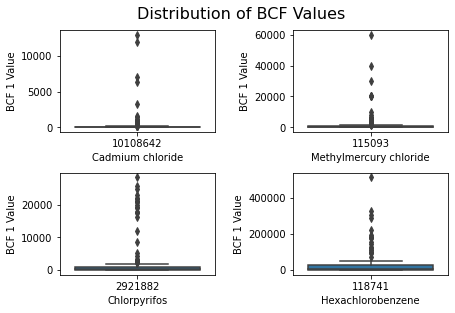

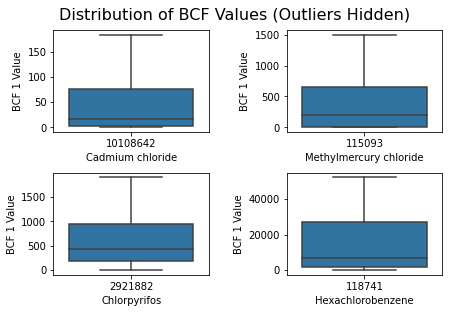

In [21]:
# Look at distribution of BCF data points for a single compound --> is it normal distribution? skewed?
# Question is if we can reasonably use arithmetic mean, or if skewed geometric mean

# Plot histograms for top 5 repeated
# eco.loc[eco["BCF 1 Unit"] == "L/kg", "CAS Number"].value_counts()
l = eco['CAS Number'].value_counts()[:4].index.tolist()
names = ['Cadmium chloride', 'Methylmercury chloride', 'Chlorpyrifos', 'Hexachlorobenzene']
# print(l)

filt = eco['CAS Number'].isin(l)
top = eco[filt]
# top5['CAS Number']
# top5.boxplot(column = 'BCF 1 Value', by = 'CAS Number')
# eco[eco["CAS Number"] == '10108642'].plot.hist(bins=10)

fig, axes = plt.subplots(2, 2)
fig.suptitle('Distribution of BCF Values', fontsize=16)
fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.5)
# fig.tight_layout()
l_axes = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]

for i in range(4):
    ax = sns.boxplot(data=top[top['CAS Number'] == l[i]], x='CAS Number', y='BCF 1 Value', ax=l_axes[i])
    ax.set(xlabel=names[i])

fig, axes = plt.subplots(2, 2)
fig.suptitle('Distribution of BCF Values (Outliers Hidden)', fontsize=16)
fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.5)

# fig.tight_layout()
l_axes = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]
for i in range(4):
    ax = sns.boxplot(data=top[top['CAS Number'] == l[i]], x='CAS Number', y='BCF 1 Value', ax=l_axes[i], showfliers=False)
    ax.set(xlabel=names[i])

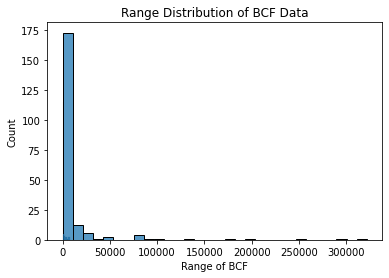

In [46]:
# Histogram of BCF range distributions
eco_distribution = eco.groupby('CAS Number')["BCF 1 Value"].agg(['min', 'max']).reset_index()
eco_distribution["Range"] = eco_distribution["max"] - eco_distribution["min"]
# eco_distribution

ax1 = sns.histplot(data=eco_distribution, x="Range", bins=30)
ax1.set(xlabel = "Range of BCF")
ax1.set_title("Range Distribution of BCF Data")

In [51]:
# Filter stage
# Filter for response site = whole body or muscle tissue
filt = eco["Response Site"] == "Whole organism"
eco = eco[filt]

# Filter for only common species - Rainbow trout, Common carp, fathead minnows
# First see how many unique compounds if we just use one species
# Trout, Minnow or Carp in name
fish = ["Trout", "Carp", "Minnow"]
filt = (eco["Species Common Name"].str.contains(fish[0])) | (eco["Species Common Name"].str.contains(fish[1])) | (eco["Species Common Name"].str.contains(fish[2]))
eco = eco[filt]

# Merge CAS Number with multiple values by finding median

# first group by CAS Number, then find median
# get rid of all duplicates
# replace CAS Number BCF with median
# take log of median make into logBCF

ecofinal = eco.groupby('CAS Number')["BCF 1 Value"].median().reset_index()
ecofinal.columns = ['CAS', 'BCF 1 Value']

# Remove zeroes, calculate Log BCF (log is natural, log10 is base 10)
ecofinal = ecofinal[ecofinal['BCF 1 Value'] != 0]
ecofinal['logBCF'] = np.log10(ecofinal['BCF 1 Value'])

# Get useful subset
ecofinal.drop(columns=['BCF 1 Value'], inplace=True)
ecofinal["Dataset"] = "eco"
ecofinal

,CAS,logBCF,Dataset
0,100005,2.012837,eco
1,100027,1.903090,eco
2,10102188,1.117271,eco
3,10161338,1.113943,eco
4,104405,2.510679,eco
...,...,...,...
201,96300957,2.925312,eco
202,96300979,3.650599,eco
203,96489713,3.152288,eco
204,98544,2.079181,eco


Text(0.5, 1.0, 'Histogram of logBCF')

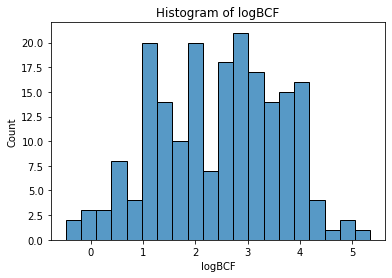

In [71]:
# distribution after log transformation
ax2 = sns.histplot(data=ecofinal, x="logBCF", bins=20)
ax2.set(xlabel = "logBCF")
ax2.set_title("Histogram of logBCF")

In [52]:
# Format CAS number with dashes for interpretation
# Up to ten digits long with xxxxxxx-yy-z format
ecofinal['CAS'] = ecofinal['CAS'].map(lambda s: s[:-3] + '-' + s[-3:-1] + '-' +s[-1:])
ecofinal

,CAS,logBCF,Dataset
0,100-00-5,2.012837,eco
1,100-02-7,1.903090,eco
2,10102-18-8,1.117271,eco
3,10161-33-8,1.113943,eco
4,104-40-5,2.510679,eco
...,...,...,...
201,96300-95-7,2.925312,eco
202,96300-97-9,3.650599,eco
203,96489-71-3,3.152288,eco
204,98-54-4,2.079181,eco


In [53]:
# Remove CAS numbers that are incorrectly formatted
# In this case there appears to be none
def is_cas(m):
    cas_pattern = re.compile('(\d+)-(\d\d)-(\d)')
    return bool(cas_pattern.match(m))

# Remove CAS numbers that are incorrectly formatted
ecofinal = ecofinal[ecofinal["CAS"].apply(is_cas)]
ecofinal

,CAS,logBCF,Dataset
0,100-00-5,2.012837,eco
1,100-02-7,1.903090,eco
2,10102-18-8,1.117271,eco
3,10161-33-8,1.113943,eco
4,104-40-5,2.510679,eco
...,...,...,...
201,96300-95-7,2.925312,eco
202,96300-97-9,3.650599,eco
203,96489-71-3,3.152288,eco
204,98-54-4,2.079181,eco


In [54]:
# Function for retrieving SMILES from CAS registry number
# Return SMILES if found, else NaN
# print(cirpy.resolve('105-67-9', 'smiles'))

ecofinal['SMILES'] = ecofinal['CAS'].map(lambda x: cirpy.resolve(x, 'smiles'))
ecofinal

,CAS,logBCF,Dataset,SMILES
0,100-00-5,2.012837,eco,[O-][N+](=O)c1ccc(Cl)cc1
1,100-02-7,1.903090,eco,Oc1ccc(cc1)[N+]([O-])=O
2,10102-18-8,1.117271,eco,[Na+].[Na+].[O-][Se]([O-])=O
3,10161-33-8,1.113943,eco,C[C@]12C=CC3=C4CCC(=O)C=C4CC[C@H]3[C@@H]1CC[C@...
4,104-40-5,2.510679,eco,CCCCCCCCCc1ccc(O)cc1
...,...,...,...,...
201,96300-95-7,2.925312,eco,CC(C)CCCCCCCO[P](=O)(Oc1ccccc1)Oc2ccccc2.O=[P]...
202,96300-97-9,3.650599,eco,CC(C)c1ccccc1O[P](=O)(Oc2ccccc2)Oc3ccccc3.O=[P...
203,96489-71-3,3.152288,eco,CC(C)(C)N1N=CC(=C(Cl)C1=O)SCc2ccc(cc2)C(C)(C)C
204,98-54-4,2.079181,eco,CC(C)(C)c1ccc(O)cc1


In [56]:
# Manually recover failed SMILES conversions through PubChem
ecofinal.loc[ecofinal["SMILES"].isnull()]

# ecofinal.at[30, 'SMILES'] = 'COP(=S)(OC)OC1=C(C=C(C=C1)Cl)[N+]#[C-]'
# ecofinal.at[91, 'SMILES'] = 'CC(C)OC(=O)C(C(=O)OC(C)C)(Cl)Cl'
# ecofinal.at[103, 'SMILES'] = 'CC(C)OC(=O)C(C(=O)OC(C)C)Cl'
# ecofinal.at[257, 'SMILES'] = 'CC1=CC2=C(C=C1C)N(C=N2)C3C(C(C(O3)CO)OP(=O)([O-])OC(C)CNC(=O)CCC4(C(C5C6(C(C(C(=C(C7=NC(=CC8=NC(=C(C4=N5)C)C(C8(C)C)CCC(=O)N)C(C7(C)CC(=O)N)CCC(=O)N)C)[N-]6)CCC(=O)N)(C)CC(=O)N)C)CC(=O)N)C)O.[C-]#N.[Co+3]'
# ecofinal.at[270, 'SMILES'] = 'C(C(C(C(F)(F)Cl)(F)F)(F)F)(C(C(OC(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(F)F.[K+]'

ecofinal.at[63, 'SMILES'] = 'CCCCCCCCCC(CC)C1=CC=C(C=C1)S(=O)(=O)[O-][Na+]'

In [57]:
# KOW will not be useful in predicting BCF for PFAS substances
# need to get rid of CAS numbers with "NA" in them

ucifinal = uci.drop(columns = ["LogKOW", "KOW type", "Name"])
ucifinal["Dataset"] = "uci"
ucifinal["CAS"] = ucifinal["CAS"].str.strip()
ucifinal

,CAS,SMILES,logBCF,Dataset
0,105-67-9,Oc1ccc(cc1C)C,1.18,uci
1,108-39-4,Oc1cccc(c1)C,1.03,uci
2,113136-77-9,O=C(O)C2CC2(C(=O)Nc1ccc(cc1Cl)Cl),-0.40,uci
3,114311-32-9,O=C(O)c2cc(cnc2(C1=NC(=O)C(N1)(C)C(C)C))COC,-1.00,uci
4,1689-84-5,N#Cc1cc(c(O)c(c1)Br)Br,0.84,uci
...,...,...,...,...
1053,V-Mey_NA_04,FC(F)C(F)(F)Oc1ccc(cc1)C(C)(C)C(C)C(C)C,3.71,uci
1054,V-Mey_NA_05,FC(F)C(F)(F)Oc1ccc(cc1)C(C)(C)CC(C)(C)C,3.92,uci
1055,V-Mey_NA_06,FC(F)C(F)(F)Oc1ccc(cc1)C(c2ccc(OC(F)(F)C(F)F)c...,3.76,uci
1056,V-Mey_NA_07,FC(F)C(F)(F)Oc1ccc(cc1)C(c2ccc(OC(F)(F)C(F)F)c...,3.19,uci


In [58]:
def is_cas(m):
    cas_pattern = re.compile('(\d+)-(\d\d)-(\d)')
    return bool(cas_pattern.match(m))

# Remove CAS numbers that are incorrectly formatted
ucifinal = ucifinal[ucifinal["CAS"].apply(is_cas)]
ucifinal

,CAS,SMILES,logBCF,Dataset
0,105-67-9,Oc1ccc(cc1C)C,1.18,uci
1,108-39-4,Oc1cccc(c1)C,1.03,uci
2,113136-77-9,O=C(O)C2CC2(C(=O)Nc1ccc(cc1Cl)Cl),-0.40,uci
3,114311-32-9,O=C(O)c2cc(cnc2(C1=NC(=O)C(N1)(C)C(C)C))COC,-1.00,uci
4,1689-84-5,N#Cc1cc(c(O)c(c1)Br)Br,0.84,uci
...,...,...,...,...
1040,99-54-7,O=[N+](c1cc(c(cc1)Cl)Cl)[O-],1.82,uci
1041,99-62-7,c1cc(cc(c1)C(C)C)C(C)C,3.22,uci
1042,99-65-0,O=[N+]([O-])c1cccc(c1)[N+](=O)[O-],0.77,uci
1043,99-71-8,CC(c1ccc(cc1)O)CC,1.35,uci


In [61]:
# We still have missing values from being unable to resolve SMILES notation:
ecofinal.dropna(subset=['SMILES'], inplace=True)
ucifinal.dropna(subset=['SMILES', 'logBCF'], inplace=True)

# ucifinal.isnull().sum()
# ecofinal.isnull().sum()

In [62]:
# Finally concatenate the two datasets
bcf = pd.concat([ecofinal, ucifinal])

# How many distinct compounds are there in this dataset?
print("There are ", bcf["CAS"].nunique(), " unique compounds")

# There are duplicates. If same CAS number, will need to choose UCI datapoint over ECO
bcftot = bcf.sort_values('Dataset', ascending=False).drop_duplicates(subset='CAS', keep='first').reset_index(drop=True)
bcftot

There are  1097  unique compounds


,CAS,logBCF,Dataset,SMILES
0,2691-41-0,-0.300000,uci,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...
1,541-73-1,2.440000,uci,Clc1cc(ccc1)Cl
2,55219-65-3,1.320000,uci,OC(C(Oc1ccc(cc1)Cl)n2ncnc2)C(C)(C)C
3,55179-31-2/70585-36-3,2.310000,uci,OC(C(Oc1ccc(cc1)c2ccccc2)n3ncnc3)C(C)(C)C
4,5510-99-6,2.470000,uci,Oc1c(cccc1C(CC)C)C(CC)C
...,...,...,...,...
1092,59756-60-4,0.511883,eco,CN1C=C(c2ccccc2)C(=O)C(=C1)c3cccc(c3)C(F)(F)F
1093,58-89-9,3.230449,eco,ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl
1094,58-73-1,1.424882,eco,CN(C)CCOC(c1ccccc1)c2ccccc2
1095,586-76-5,1.000000,eco,OC(=O)c1ccc(Br)cc1


In [63]:
# Print to csv - bcfgeneral.csv has unfiltered species data
bcftot.to_csv('data/dataprocessing/bcfgeneralcommon.csv')

In [97]:
# Now we collect and collate our PFAS dataset
# Buckhard PFAS, ITRC PFAS
burk = pd.read_excel('Burkhard_PFAS.xlsx')
itrc = pd.read_excel('ITRC_PFAS.xlsx', sheet_name = "BCF-BAF Database", header=6)

In [98]:
# rename and drop all other columns except name, CAS, logBCF, SMILES
burk.rename(columns={"CAS no.": "CAS", "Log BCF SS (EnvPFAS)": "logBCF"}, inplace=True)
burk.dropna(subset=['CAS', 'logBCF'], inplace=True)
burkfinal = burk[["Chemical", "CAS", "logBCF", "SMILES"]]
burkfinal['Dataset'] = 'burk'
burkfinal.reset_index(drop=True)

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Chemical,CAS,logBCF,SMILES,Dataset
0,PFBA,45048-62-2,1.18,C(=O)(C(C(C(F)(F)F)(F)F)(F)F)[O-],burk
1,PFPeA,45167-47-3,-0.05,C(=O)(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)[O-],burk
2,PFHxA,92612-52-7,0.98,C(=O)(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)[O-],burk
3,PFHpA,120885-29-2,1.26,C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(...,burk
4,PFOA,45285-51-6,1.36,C(=O)(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F...,burk
5,PFNA,72007-68-2,2.78,C(=O)(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F...,burk
6,PFDA,73829-36-4,3.79,C(=O)(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)...,burk
7,PFUnDA,196859-54-8,3.57,C(=O)(C(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)...,burk
8,PFDoDA,171978-95-3,3.64,C(=O)(C(C(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(...,burk
9,PFTrDA,862374-87-6,4.34,C(=O)(C(C(C(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F...,burk


In [99]:
# Calculate logBCF, remove non fish species, bad CAS numbers
itrc.rename(columns={"CAS No.": "CAS", "Acronym": "Chemical"}, inplace=True)
itrc.dropna(subset=['CAS', 'BCF'], inplace=True)
itrc

,PFAS Name,Chemical,Number of Carbons,CAS,Mol. Wt. (g/mol),BCF Min,BCF Max,BCF,BAF Min,BAF Max,...,Lab or Field or Model Study,Location,Freshwater/marine/estuarine,Waterbody Description,Organism Common Name,Scientific Name,Tissue Type (valid values),Wet/Dry/Lipid Basis,Reviewer Notes,Unique Identifier
58,Perfluorobutanoic acid (C4),PFBA,4,375-22-4,214.04,NaN,NaN,100.00,NaN,NaN,...,Lab,Singapore,Freshwater,Lab,Zebrafish,Danio rerio,Plasma,Wet,Low Exposure Group; 3 replicates consisting ea...,76
59,Perfluorobutanoic acid (C4),PFBA,4,375-22-4,214.04,NaN,NaN,72.44,NaN,NaN,...,Lab,Singapore,Freshwater,Lab,Zebrafish,Danio rerio,Plasma,Wet,High Exposure Group; 3 replicates consisting e...,77
60,Perfluorobutanoic acid (C4),PFBA,4,375-22-4,214.04,NaN,NaN,141.25,NaN,NaN,...,Lab,Singapore,Freshwater,Lab,Zebrafish,Danio rerio,Liver,Wet,Low Exposure Group; 3 replicates consisting ea...,78
61,Perfluorobutanoic acid (C4),PFBA,4,375-22-4,214.04,NaN,NaN,63.10,NaN,NaN,...,Lab,Singapore,Freshwater,Lab,Zebrafish,Danio rerio,Liver,Wet,High Exposure Group; 3 replicates consisting e...,79
62,Perfluorobutanoic acid (C4),PFBA,4,375-22-4,214.04,NaN,NaN,2.75,NaN,NaN,...,Lab,Singapore,Freshwater,Lab,Zebrafish,Danio rerio,Muscle,Wet,Low Exposure Group; 3 replicates consisting ea...,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,Perfluorooctanoic acid (C8),PFOA,8,335-67-1,414.07,NaN,NaN,10.00,NaN,NaN,...,Field,"Taishyo River H, Japan",Freshwater,"Rivers, coastal lagoons, wetands",Turtles,Trachemys scripta elegans and Chinemys reeevesii,Plasma,Wet,The ratio of geomean in serum to surface water...,1588
1280,Perfluorooctanoic acid (C8),PFOA,8,335-67-1,414.07,NaN,NaN,15.80,NaN,NaN,...,Field,"Daijagaike Pond I, Japan",Freshwater,"Rivers, coastal lagoons, wetands",Turtles,Trachemys scripta elegans and Chinemys reeevesii,Plasma,Wet,The ratio of geomean in serum to surface water...,1589
1281,Perfluorooctanoic acid (C8),PFOA,8,335-67-1,414.07,NaN,NaN,10.00,NaN,NaN,...,Field,"Uji River Waterway J, Japan",Freshwater,"Rivers, coastal lagoons, wetands",Turtles,Trachemys scripta elegans and Chinemys reeevesii,Plasma,Wet,The ratio of geomean in serum to surface water...,1590
1357,6:6 perfluoroalkyl phosphinic acid,6:6 PFPiA,12,40143-77-9,0.00,NaN,NaN,1219.00,NaN,NaN,...,Lab,NaN,NaN,NaN,Carp,Cyprinus carpio,Whole,NaN,Not considering the biotransformation of PFPiAs,1666


In [100]:
# Remove CAS numbers that are incorrectly formatted
def is_cas(m):
    cas_pattern = re.compile('(\d+)-(\d\d)-(\d)')
    return bool(cas_pattern.match(m))

# Remove CAS numbers that are incorrectly formatted
itrc["CAS"] = itrc["CAS"].str.strip()
itrc = itrc[itrc["CAS"].apply(is_cas)]
itrc

,PFAS Name,Chemical,Number of Carbons,CAS,Mol. Wt. (g/mol),BCF Min,BCF Max,BCF,BAF Min,BAF Max,...,Lab or Field or Model Study,Location,Freshwater/marine/estuarine,Waterbody Description,Organism Common Name,Scientific Name,Tissue Type (valid values),Wet/Dry/Lipid Basis,Reviewer Notes,Unique Identifier
58,Perfluorobutanoic acid (C4),PFBA,4,375-22-4,214.04,NaN,NaN,100.00,NaN,NaN,...,Lab,Singapore,Freshwater,Lab,Zebrafish,Danio rerio,Plasma,Wet,Low Exposure Group; 3 replicates consisting ea...,76
59,Perfluorobutanoic acid (C4),PFBA,4,375-22-4,214.04,NaN,NaN,72.44,NaN,NaN,...,Lab,Singapore,Freshwater,Lab,Zebrafish,Danio rerio,Plasma,Wet,High Exposure Group; 3 replicates consisting e...,77
60,Perfluorobutanoic acid (C4),PFBA,4,375-22-4,214.04,NaN,NaN,141.25,NaN,NaN,...,Lab,Singapore,Freshwater,Lab,Zebrafish,Danio rerio,Liver,Wet,Low Exposure Group; 3 replicates consisting ea...,78
61,Perfluorobutanoic acid (C4),PFBA,4,375-22-4,214.04,NaN,NaN,63.10,NaN,NaN,...,Lab,Singapore,Freshwater,Lab,Zebrafish,Danio rerio,Liver,Wet,High Exposure Group; 3 replicates consisting e...,79
62,Perfluorobutanoic acid (C4),PFBA,4,375-22-4,214.04,NaN,NaN,2.75,NaN,NaN,...,Lab,Singapore,Freshwater,Lab,Zebrafish,Danio rerio,Muscle,Wet,Low Exposure Group; 3 replicates consisting ea...,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,Perfluorooctanoic acid (C8),PFOA,8,335-67-1,414.07,NaN,NaN,10.00,NaN,NaN,...,Field,"Taishyo River H, Japan",Freshwater,"Rivers, coastal lagoons, wetands",Turtles,Trachemys scripta elegans and Chinemys reeevesii,Plasma,Wet,The ratio of geomean in serum to surface water...,1588
1280,Perfluorooctanoic acid (C8),PFOA,8,335-67-1,414.07,NaN,NaN,15.80,NaN,NaN,...,Field,"Daijagaike Pond I, Japan",Freshwater,"Rivers, coastal lagoons, wetands",Turtles,Trachemys scripta elegans and Chinemys reeevesii,Plasma,Wet,The ratio of geomean in serum to surface water...,1589
1281,Perfluorooctanoic acid (C8),PFOA,8,335-67-1,414.07,NaN,NaN,10.00,NaN,NaN,...,Field,"Uji River Waterway J, Japan",Freshwater,"Rivers, coastal lagoons, wetands",Turtles,Trachemys scripta elegans and Chinemys reeevesii,Plasma,Wet,The ratio of geomean in serum to surface water...,1590
1357,6:6 perfluoroalkyl phosphinic acid,6:6 PFPiA,12,40143-77-9,0.00,NaN,NaN,1219.00,NaN,NaN,...,Lab,NaN,NaN,NaN,Carp,Cyprinus carpio,Whole,NaN,Not considering the biotransformation of PFPiAs,1666


In [60]:
# How many distinct compounds are there in this dataset?
print("There are ", itrc["CAS No."].nunique(), " unique compounds")
itrc["Acronym"].value_counts()

There are  27  unique compounds


PFOS            245
PFOA            177
PFDA            140
PFNA            135
PFHxS           114
PFUnDA          105
PFDoDA           56
PFHpA            52
PFHxA            51
PFPeA            38
PFBS             35
FOSA             32
F53B             31
L-PFOS           28
Br-PFOS          21
PFTeDA           20
PFBA             20
PFTrDA           19
OBS              14
PFDS              9
3+4+5m-PFOS       6
6m-PFOS           6
1m-PFOS           5
PFHpS             5
PFECHS            5
EtFOSAA           4
PFunDA            4
MeFOSAA           3
L-FOSA            3
HFPO-DA           3
HFPO-TA           3
6:2 Cl-PFESA      3
8:2 Cl-PFESA      3
Br-FOSA           3
4:2 Cl-PFESA      2
PFPCPeS           1
6:6 PFPiA         1
8:8 PFPiA         1
6:2 FTSA          1
Name: Acronym, dtype: int64

In [63]:
# Remove Turtles, eel, daphnia
# Maybe remove yearling carp?
itrc["Organism Common Name"].value_counts()

Zebrafish                 119
Juvenile Rainbow trout     21
Turtles                    19
European eel                7
Daphnia                     6
yearling carp               4
Carp                        2
Name: Organism Common Name, dtype: int64

In [64]:
# Select Whole
itrc["Tissue Type (valid values)"].value_counts()

Plasma     43
Whole      36
Liver      31
Muscle     30
Ovary      24
Carcass     7
Blood       7
Name: Tissue Type (valid values), dtype: int64

In [106]:
# Filter stage
# Filter for response site = whole body
filt = itrc["Tissue Type (valid values)"] == "Whole"
itrc = itrc[filt]

# Filter for fish
filt = itrc["Organism Common Name"].isin(["Zebrafish", "Juvenile Rainbow trout", "yearling carp", "Carp"])
itrc = itrc[filt]

# Merge CAS Number with multiple values by finding median
itrcfinal = itrc.groupby(['Chemical', 'CAS'])["BCF"].median().reset_index()

# Remove zeroes, calculate Log BCF (log is natural, log10 is base 10)
itrcfinal = itrcfinal[itrcfinal['BCF'] != 0]
itrcfinal['logBCF'] = np.log10(itrcfinal['BCF'])

# Get useful subset
itrcfinal = itrcfinal[["Chemical", "CAS", "logBCF"]]
itrcfinal["Dataset"] = "itrc"

itrcfinal['SMILES'] = itrcfinal['CAS'].map(lambda x: cirpy.resolve(x, 'smiles'))
itrcfinal

,Chemical,CAS,logBCF,Dataset,SMILES
0,6:6 PFPiA,40143-77-9,3.086004,itrc,None
1,8:8 PFPiA,40143-79-1,2.900367,itrc,None
2,PFBA,375-22-4,1.184123,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)F
3,PFBS,375-73-5,1.371437,itrc,O[S](=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
4,PFDA,335-76-2,3.889259,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...
5,PFDoDA,307-55-1,4.000000,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...
6,PFHxA,307-24-4,0.995196,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
7,PFHxS,355-46-4,2.323262,itrc,O[S](=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...
8,PFNA,375-95-1,3.127327,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...
9,PFOA,335-67-1,1.931432,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...


In [97]:
# Need to manually set missing SMILES
itrcfinal.at[0, "SMILES"] = "C(C(C(C(F)(F)P(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O)(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)F"
itrcfinal.at[1, "SMILES"] = "C(C(C(C(C(F)(F)P(=O)(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O)(F)F)(F)F)(F)F)(C(C(C(F)(F)F)(F)F)(F)F)(F)F"
itrcfinal

,Chemical,CAS,logBCF,Dataset,SMILES
0,6:6 PFPiA,40143-77-9,3.086004,itrc,C(C(C(C(F)(F)P(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)...
1,8:8 PFPiA,40143-79-1,2.900367,itrc,C(C(C(C(C(F)(F)P(=O)(C(C(C(C(C(C(C(C(F)(F)F)(F...
2,PFBA,375-22-4,1.184123,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)F
3,PFBS,375-73-5,1.371437,itrc,O[S](=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
4,PFDA,335-76-2,3.889259,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...
5,PFDoDA,307-55-1,4.000000,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...
6,PFHxA,307-24-4,0.995196,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
7,PFHxS,355-46-4,2.323262,itrc,O[S](=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...
8,PFNA,375-95-1,3.127327,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...
9,PFOA,335-67-1,1.931432,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...


In [107]:
# Merge itrc with burk, keep burk as first option
pfas = pd.concat([burkfinal, itrcfinal])

# There are duplicates. If same CAS number, will need to choose burk datapoint over itrc
pfastot = pfas.sort_values('Dataset', ascending=True).drop_duplicates(subset='CAS', keep='first').reset_index(drop=True)
pfastot

,Chemical,CAS,logBCF,SMILES,Dataset
0,PFBA,45048-62-2,1.180000,C(=O)(C(C(C(F)(F)F)(F)F)(F)F)[O-],burk
1,8:2 Cl-PFESA,83329-89-9,0.400000,C(C(C(C(C(F)(F)Cl)(F)F)(F)F)(F)F)(C(C(C(OC(C(F...,burk
2,F-53B (6:2 Cl-PFESA),73606-19-6,2.850000,C(C(C(C(F)(F)Cl)(F)F)(F)F)(C(C(OC(C(F)(F)S(=O)...,burk
3,6:2 FTSA,27619-97-2,1.540000,O[S](=O)(=O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,burk
4,8:2 FTOH,678-39-7,2.500000,OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,burk
5,C8/C8 PFPiA,40143-79-1,8.300000,C(C(C(C(C(F)(F)P(=O)(C(C(C(C(C(C(C(C(F)(F)F)(F...,burk
6,C6/C6 PFPiA,40143-77-9,5.120000,C(C(C(C(F)(F)P(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)...,burk
7,PFOPA,40143-78-0,1.920000,C(C(C(C(C(F)(F)P(=O)(O)O)(F)F)(F)F)(F)F)(C(C(C...,burk
8,PFHxPA,40143-76-8,1.460000,C(C(C(C(F)(F)P(=O)(O)O)(F)F)(F)F)(C(C(F)(F)F)(...,burk
9,SAmPAP,2965-52-8,1.420000,CCN(CCO[P](O)(=O)OCCN(CC)[S](=O)(=O)C(F)(F)C(F...,burk


In [108]:
# Print to csv
pfastot.to_csv('data/dataprocessing/bcfpfas.csv')